In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, json, math, random, time, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from PIL import ImageFile
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
torch.set_float32_matmul_precision('high')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DATASET_ROOT='/content/drive/MyDrive/Dataset_PBL6_MAIN/dataset'
OUTPUT_DIR='/content/drive/MyDrive/Dataset_PBL6_MAIN/outputs_resnet'
os.makedirs(OUTPUT_DIR, exist_ok=True)
IMG_SIZE=224
BATCH_SIZE=32
VAL_SIZE=0.15
TEST_SIZE=0.15
EPOCHS=30
MODEL_CHOICE='resnet18'
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
ImageFile.LOAD_TRUNCATED_IMAGES=True

In [ ]:
base_ds=datasets.ImageFolder(DATASET_ROOT)
class_names=base_ds.classes
y=[s[1] for s in base_ds.samples]
sss1=StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
train_val_idx, test_idx=next(sss1.split(np.zeros(len(y)), y))
y_train_val=[y[i] for i in train_val_idx]
sss2=StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=SEED)
train_idx, val_idx=next(sss2.split(np.zeros(len(train_val_idx)), y_train_val))
train_indices=[train_val_idx[i] for i in train_idx]
val_indices=[train_val_idx[i] for i in val_idx]
train_size=len(train_indices); val_size=len(val_indices); test_size=len(test_idx)
num_classes=len(class_names)
with open(os.path.join(OUTPUT_DIR,'labels.json'),'w',encoding='utf-8') as f: json.dump({'classes':class_names},f,ensure_ascii=False,indent=2)
train_mean_loader=DataLoader(Subset(datasets.ImageFolder(DATASET_ROOT,transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])),train_indices),batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)
n=0; channel_sum=torch.zeros(3); channel_sqsum=torch.zeros(3)
for x,_ in train_mean_loader:
  x=x.view(x.size(0),x.size(1),-1)
  channel_sum+=x.sum(dim=(0,2))
  channel_sqsum+=(x**2).sum(dim=(0,2))
  n+=x.size(0)*x.size(2)
mean=(channel_sum/n).tolist()
std=(torch.sqrt(channel_sqsum/n - torch.tensor(mean)**2)).tolist()
with open(os.path.join(OUTPUT_DIR,'norm.json'),'w') as f: json.dump({'mean':mean,'std':std},f)

In [ ]:
tfm_train=transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE,scale=(0.8,1.0)),transforms.RandomHorizontalFlip(),transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1,hue=0.02),transforms.ToTensor(),transforms.Normalize(mean,std)])
tfm_eval=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor(),transforms.Normalize(mean,std)])
dataset_full=datasets.ImageFolder(DATASET_ROOT,transform=tfm_train)
dataset_eval=datasets.ImageFolder(DATASET_ROOT,transform=tfm_eval)
train_ds=Subset(dataset_full,train_indices)
val_ds=Subset(dataset_eval,val_indices)
test_ds=Subset(dataset_eval,test_idx)
train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)
test_loader=DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)

In [ ]:
def build_model(name,num_classes):
  if name=='resnet18':
    m=models.resnet18(weights=None)
  elif name=='resnet34':
    m=models.resnet34(weights=None)
  else:
    m=models.resnet18(weights=None)
  in_features=m.fc.in_features
  m.fc=nn.Linear(in_features,num_classes)
  for module in m.modules():
    if isinstance(module,nn.Conv2d):
      nn.init.kaiming_normal_(module.weight,mode='fan_out',nonlinearity='relu')
      if module.bias is not None: nn.init.zeros_(module.bias)
    elif isinstance(module,nn.BatchNorm2d):
      nn.init.ones_(module.weight); nn.init.zeros_(module.bias)
    elif isinstance(module,nn.Linear):
      nn.init.xavier_uniform_(module.weight); nn.init.zeros_(module.bias)
  return m
model=build_model(MODEL_CHOICE,num_classes).to(DEVICE)

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=3e-4,weight_decay=1e-4)
steps_per_epoch=len(train_loader)
scheduler=OneCycleLR(optimizer,max_lr=1e-3,epochs=EPOCHS,steps_per_epoch=steps_per_epoch,pct_start=0.3,div_factor=10,final_div_factor=100)
scaler=torch.cuda.amp.GradScaler(enabled=(DEVICE=='cuda'))

/tmp/ipython-input-3126255302.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=torch.cuda.amp.GradScaler(enabled=(DEVICE=='cuda'))


In [ ]:
def epoch_train(m,loader):
  m.train(); total=0; correct=0; loss_sum=0.0
  for x,y in loader:
    x=x.to(DEVICE,non_blocking=True); y=y.to(DEVICE,non_blocking=True)
    optimizer.zero_grad(set_to_none=True)
    with torch.cuda.amp.autocast(enabled=(DEVICE=='cuda')):
      out=m(x); loss=criterion(out,y)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()
    loss_sum+=loss.item()*x.size(0)
    pred=out.argmax(1)
    correct+=(pred==y).sum().item(); total+=y.size(0)
  return loss_sum/total, correct/total
def epoch_eval(m,loader):
  m.eval(); total=0; correct=0; loss_sum=0.0
  with torch.no_grad():
    for x,y in loader:
      x=x.to(DEVICE,non_blocking=True); y=y.to(DEVICE,non_blocking=True)
      out=m(x); loss=criterion(out,y)
      loss_sum+=loss.item()*x.size(0)
      pred=out.argmax(1); correct+=(pred==y).sum().item(); total+=y.size(0)
  return loss_sum/total, correct/total

In [ ]:
best_acc=0.0
best_loss=float('inf')
patience=7
wait=0
history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
for epoch in range(EPOCHS):
  t0=time.time()
  tl,ta=epoch_train(model,train_loader)
  vl,va=epoch_eval(model,val_loader)
  history['train_loss'].append(tl); history['train_acc'].append(ta); history['val_loss'].append(vl); history['val_acc'].append(va)
  improved=va>best_acc or vl<best_loss
  if vl<best_loss: best_loss=vl
  if va>best_acc: best_acc=va
  if improved:
    torch.save({'model_state':model.state_dict(),'classes':class_names,'mean':mean,'std':std,'img_size':IMG_SIZE,'epoch':epoch},os.path.join(OUTPUT_DIR,'NhanDienVatTuYTe_best.pth'))
    wait=0
  else:
    wait+=1
  t1=time.time()
  print(epoch+1,tl,ta,vl,va,round(t1-t0,2))
  if wait>=patience:
    break
with open(os.path.join(OUTPUT_DIR,'history.json'),'w') as f: json.dump(history,f)

/tmp/ipython-input-1483239404.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=='cuda')):


1 1.8672475929493877 0.39932284405496915 1.8278101545284229 0.4312267657992565 257.39
2 1.3703318102334605 0.5523800039832703 1.5389411555790105 0.5139405204460966 254.92
3 1.170924981925811 0.6177056363274248 1.1681351998481608 0.6287174721189591 255.56
4 0.9685173343553222 0.6870145389364668 1.1201742962833674 0.6621747211895911 254.53
5 0.8731073496517872 0.7205735909181438 1.1875915935048384 0.6287174721189591 254.72
6 0.7709196889526315 0.7549292969527982 1.298372996340897 0.6366171003717472 252.7
7 0.7000380681819874 0.780422226648078 0.8879583978741585 0.7225836431226765 251.91
8 0.6161131735722682 0.8030272854013145 0.6956297110447653 0.7774163568773235 254.79
9 0.5519656874914611 0.8213503286197968 0.5162075319254709 0.8378252788104089 248.89
10 0.4815940070712597 0.8447520414260108 0.7529535373347399 0.7681226765799256 256.52
11 0.43292507298366406 0.8627763393746266 0.4938145574583883 0.8420074349442379 252.41
12 0.37328434754975454 0.8795060744871539 0.5176515085103344 0.84

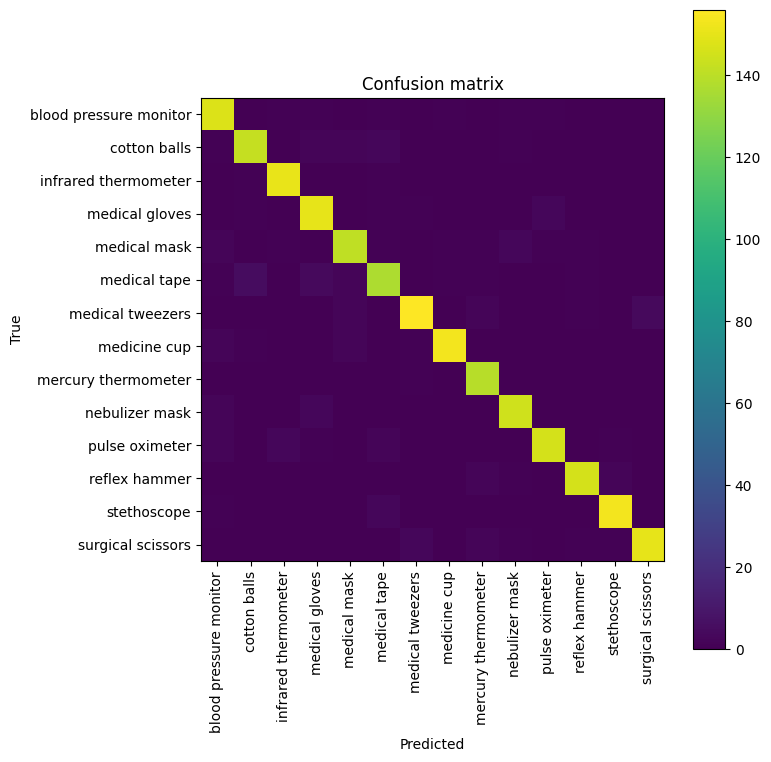

In [ ]:
ckpt=torch.load(os.path.join(OUTPUT_DIR,'NhanDienVatTuYTe_best.pth'),map_location=DEVICE)
model=build_model(MODEL_CHOICE,num_classes).to(DEVICE)
model.load_state_dict(ckpt['model_state'])
model.eval()
y_true=[]; y_pred=[]
with torch.no_grad():
  for x,y in test_loader:
    x=x.to(DEVICE); out=model(x); p=out.argmax(1).cpu().numpy().tolist(); y_pred+=p; y_true+=y.numpy().tolist()
report=classification_report(y_true,y_pred,target_names=class_names,output_dict=True,zero_division=0)
with open(os.path.join(OUTPUT_DIR,'test_report.json'),'w') as f: json.dump(report,f,ensure_ascii=False,indent=2)
cm=confusion_matrix(y_true,y_pred,labels=list(range(num_classes)))
fig=plt.figure(figsize=(8,8))
plt.imshow(cm,interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks=np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
def predict_image(img_path):
  im=datasets.folder.default_loader(img_path)
  im=tfm_eval(im).unsqueeze(0).to(DEVICE)
  with torch.no_grad():
    out=model(im); p=out.softmax(1)[0]; idx=int(torch.argmax(p).item()); conf=float(p[idx].item())
  return class_names[idx],conf
sample_path=None
if len(test_idx)>0:
  sample_path=base_ds.samples[test_idx[0]][0]
if sample_path:
  pred,conf=predict_image(sample_path)
  print(sample_path,pred,round(conf,4))

/content/drive/MyDrive/Dataset_PBL6_MAIN/dataset/medicine cup/0894.jpg medicine cup 1.0


In [ ]:
import os, json, shutil, torch
from google.colab import files
os.makedirs('/content/export', exist_ok=True)
torch.save({'model_state':model.state_dict(),'arch':MODEL_CHOICE,'img_size':IMG_SIZE,'classes':class_names,'mean':mean,'std':std},'/content/export/NhanDienVatTuYTe_best.pth')
with open('/content/export/labels.json','w',encoding='utf-8') as f: json.dump({'classes':class_names},f,ensure_ascii=False,indent=2)
with open('/content/export/norm.json','w') as f: json.dump({'mean':mean,'std':std},f)
zip_path='/content/NhanDienVatTuYTe_export.zip'
if os.path.exists(zip_path): os.remove(zip_path)
shutil.make_archive('/content/NhanDienVatTuYTe_export','zip','/content/export')
files.download('/content/NhanDienVatTuYTe_export.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

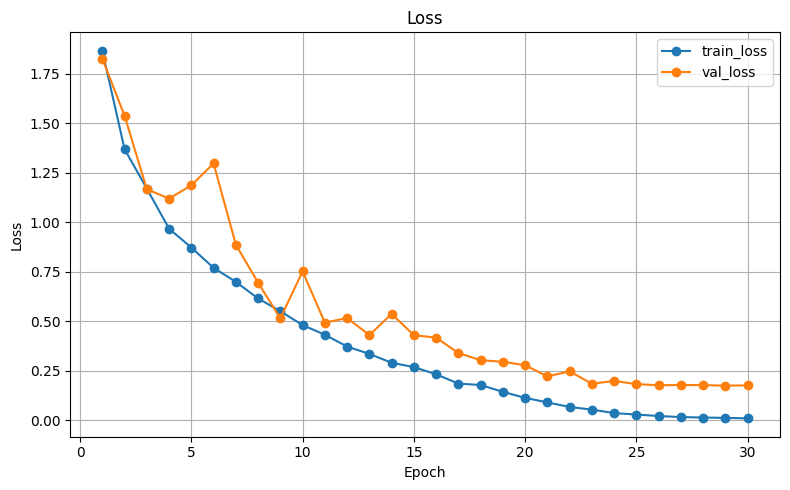

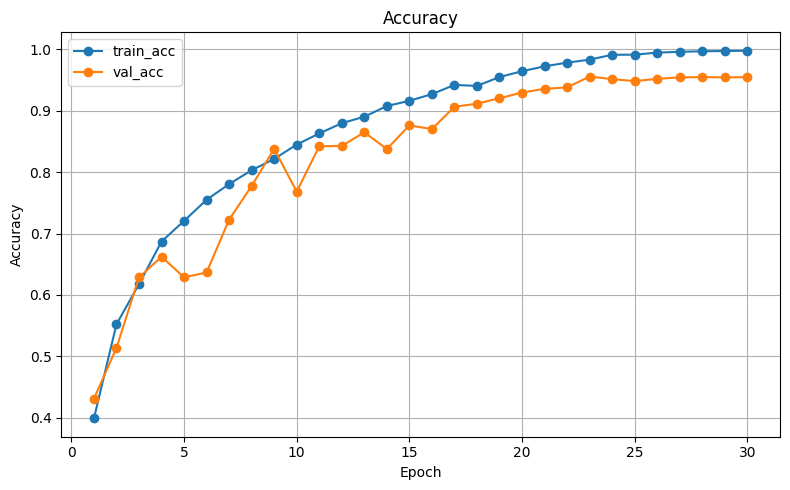

In [ ]:
import os, json, matplotlib.pyplot as plt
data=None
if 'history' in globals() and isinstance(history,dict) and all(k in history for k in ['train_loss','train_acc','val_loss','val_acc']):
  data=history
else:
  with open(os.path.join(OUTPUT_DIR,'history.json')) as f:
    data=json.load(f)
tl=data['train_loss']; ta=data['train_acc']; vl=data['val_loss']; va=data['val_acc']
epochs=range(1,len(tl)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs,tl,marker='o',label='train_loss')
plt.plot(epochs,vl,marker='o',label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
plt.figure(figsize=(8,5))
plt.plot(epochs,ta,marker='o',label='train_acc')
plt.plot(epochs,va,marker='o',label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


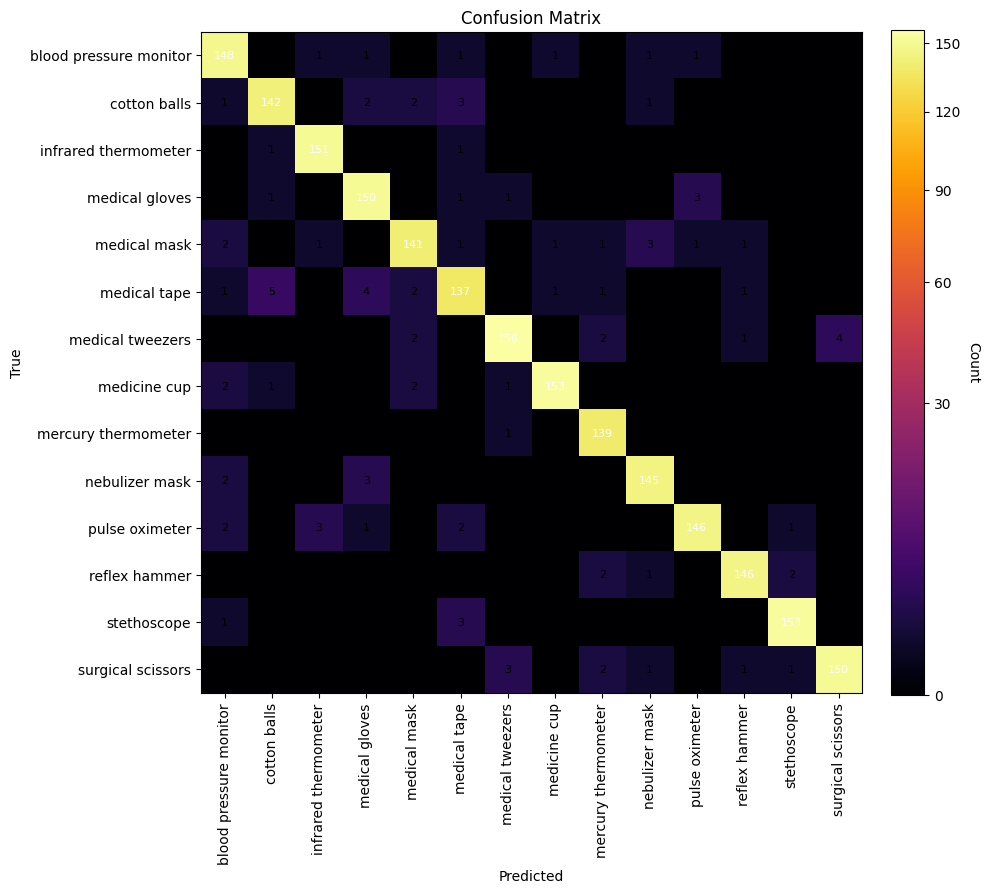

In [ ]:
from matplotlib.colors import PowerNorm
import matplotlib.ticker as mticker


fig = plt.figure(figsize=(10,10))


norm = PowerNorm(gamma=0.5, vmin=0, vmax=cm.max())

im = plt.imshow(cm, interpolation='nearest', cmap='inferno', norm=norm)
plt.title('Confusion Matrix')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Count', rotation=-90, va='bottom')

cbar.ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, prune=None))

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)


thresh = cm.max() * 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        plt.text(
            j, i, f"{val}",
            ha="center", va="center",
            fontsize=8,
            color="white" if val > thresh else "black"
        )

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.grid(False)
plt.show()



Confusion Matrix (rows = True class, cols = Predicted):
                         P:blood pressure monitor P:cotton balls           P:infrared thermometer   P:medical gloves         P:medical mask           P:medical tape           P:medical tweezers       P:medicine cup           P:mercury thermometer    P:nebulizer mask         P:pulse oximeter         P:reflex hammer          P:stethoscope            P:surgical scissors      
T:blood pressure monitor 148                      0                        1                        1                        0                        1                        0                        1                        0                        1                        1                        0                        0                        0                        
T:cotton balls           1                        142                      0                        2                        2                        3                        0               

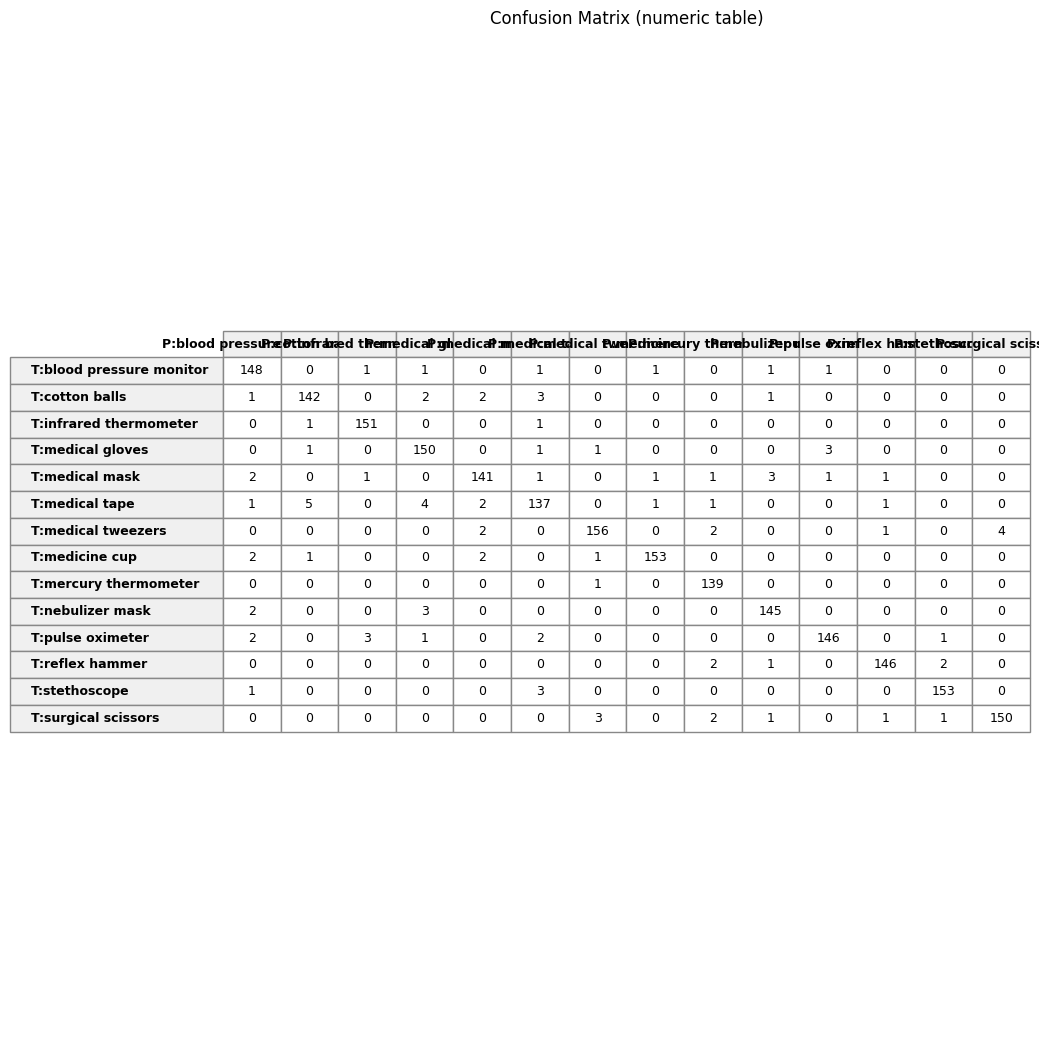

In [ ]:

import csv

print("\nConfusion Matrix (rows = True class, cols = Predicted):")
header = [""] + [f"P:{c}" for c in class_names]
rows = [[f"T:{class_names[i]}", *cm[i].tolist()] for i in range(len(class_names))]
colw = max(len(max(class_names, key=len))+3, 8)
print("".join(h.ljust(colw) for h in header))
for r in rows:
    print(r[0].ljust(colw) + "".join(str(x).ljust(colw) for x in r[1:]))

csv_path = os.path.join(OUTPUT_DIR, "confusion_matrix.csv")
with open(csv_path, "w", newline="", encoding="utf-8-sig") as f:
    w = csv.writer(f)
    w.writerow(header)
    for i in range(len(class_names)):
        w.writerow([f"T:{class_names[i]}", *cm[i].tolist()])

n = len(class_names)
fig_size = max(8, n * 0.75)
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
ax.axis("off")

table = ax.table(
    cellText=cm.astype(int),
    rowLabels=[f"T:{c}" for c in class_names],
    colLabels=[f"P:{c}" for c in class_names],
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.3)

for (r, c), cell in table.get_celld().items():
    cell.set_edgecolor("#888")
    if r == 0 or c == -1:
        cell.set_facecolor("#f0f0f0")
        cell.set_text_props(weight="bold")
    else:
        cell.set_facecolor("white")

plt.title("Confusion Matrix (numeric table)")
plt.tight_layout()
plt.show()
